# **Análise das Queimadas Realizadas no Brasil entre 2017 a 2021**

### **Introdução**

**1. Definição do Problema**

---

As queimadas representam um desafio significativo para a preservação ambiental e a segurança das comunidades. Com o aumento da frequência e intensidade das queimadas, é essencial entender os fatores que contribuem para sua ocorrência. O objetivo deste trabalho é utilizar um modelo de aprendizagem de máquina para monitorar o risco de queimadas em diferentes localidades, permitindo a implementação de políticas públicas eficazes para prevenir e mitigar esses eventos. A análise é baseada em um conjunto de dados extraído do Kaggle, que inclui informações sobre as condições climáticas, como dias sem chuva e precipitação, bem como dados sobre risco de fogo e características geográficas das áreas afetadas.

Este é um problema de aprendizado supervisionado, pois propõe a construção de um modelo de classificação que visa prever o risco de queimadas em uma localidade específica, categorizando-o em três níveis: alto, médio ou baixo. Essa previsão é baseada em um conjunto de dados históricos que inclui variáveis relevantes, como dias sem chuva, precipitação, e outros fatores ambientais. A utilização de dados rotulados permite que o modelo aprenda a relação entre essas características e a ocorrência de queimadas, proporcionando insights valiosos para a tomada de decisões e o desenvolvimento de políticas públicas de prevenção.

Informações sobre os atributos:


datahora - Data e hora em que os dados foram registrados (formato: YYYY-MM-DD HH:MM:SS).

estado - Nome do estado brasileiro onde a observação foi feita.

municipio - Nome do município correspondente à localização da observação.

bioma - Tipo de bioma da região.

diasemchuva - Número de dias de chuva.

precipitacao - Quantidade de precipitação acumulada em milímetros.

riscofogo - Nível de risco de incêndio na área, variando de baixo a alto.

latitude - Coordenada geográfica que indica a posição norte-sul.

longitude - Coordenada geográfica que indica a posição leste-oeste.



**2. Carregamento de bibliotecas e dados**

---


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from scipy.stats import truncnorm

In [75]:
from google.colab import files

In [4]:
pip install kaggle -q

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafaelrodolfo","key":"5c8767f7c38909a4751ac4bfc3acb753"}'}

In [6]:
!pwd

!kaggle datasets download -d thalitaalves/queimadas-brasil-2011-2021

/content
Dataset URL: https://www.kaggle.com/datasets/thalitaalves/queimadas-brasil-2011-2021
License(s): unknown
100% 526M/528M [00:08<00:00, 41.0MB/s]
100% 528M/528M [00:08<00:00, 67.1MB/s]


In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!unzip queimadas-brasil-2011-2021.zip -d queimadas-brasil-2011-2021

Archive:  queimadas-brasil-2011-2021.zip
  inflating: queimadas-brasil-2011-2021/focos-queimadas-brasil-2011-2021.csv  


In [3]:
df = pd.read_csv('/content/queimadas-brasil-2011-2021/focos-queimadas-brasil-2011-2021.csv')

**3. Tratamento e Limpeza dos Dados**

---

In [4]:
df.shape

(29165021, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165021 entries, 0 to 29165020
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   datahora      object 
 2   satelite      object 
 3   estado        object 
 4   municipio     object 
 5   bioma         object 
 6   diasemchuva   float64
 7   precipitacao  float64
 8   riscofogo     float64
 9   latitude      float64
 10  longitude     float64
 11  frp           float64
dtypes: float64(6), int64(1), object(5)
memory usage: 2.6+ GB


In [6]:
df.head()

,Unnamed: 0,datahora,satelite,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,0,2011/01/01 04:33:00,AQUA_M-M,SAO PAULO,ITUPEVA,Mata Atlantica,NaN,NaN,NaN,-23.14400,-47.11800,NaN
1,1,2011/01/01 09:05:48,NOAA-16N,RIO GRANDE DO NORTE,TOUROS,Caatinga,NaN,NaN,NaN,-5.32167,-35.62667,NaN
2,2,2011/01/01 12:45:00,GOES-12,BAHIA,GLORIA,Caatinga,NaN,NaN,NaN,-9.03354,-38.32000,NaN
3,3,2011/01/01 12:45:00,GOES-12,BAHIA,GLORIA,Caatinga,NaN,NaN,NaN,-9.00355,-38.33000,NaN
4,4,2011/01/01 13:00:00,GOES-12,PERNAMBUCO,FLORESTA,Caatinga,NaN,NaN,NaN,-8.81357,-38.53000,NaN


In [7]:
df.tail()

,Unnamed: 0,datahora,satelite,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
29165016,4404595,2021/09/14 04:59:00,NPP-375,GOIAS,NOVA IGUACU DE GOIAS,Cerrado,119.0,0.0,1.0,-14.34131,-49.33053,1.6
29165017,4404596,2021/09/14 04:59:00,NPP-375,GOIAS,NOVA IGUACU DE GOIAS,Cerrado,117.0,0.0,1.0,-14.34250,-49.35736,1.2
29165018,4404597,2021/09/14 04:59:00,NPP-375,GOIAS,NOVA IGUACU DE GOIAS,Cerrado,119.0,0.0,1.0,-14.34362,-49.34859,3.1
29165019,4404598,2021/09/14 04:59:00,NPP-375,GOIAS,NOVA IGUACU DE GOIAS,Cerrado,119.0,0.0,1.0,-14.34417,-49.34423,3.1
29165020,4404599,2021/09/14 04:59:00,NPP-375,GOIAS,NOVA IGUACU DE GOIAS,Cerrado,119.0,0.0,1.0,-14.34474,-49.33976,2.3


In [8]:
df = df.drop(columns=['frp', 'Unnamed: 0','satelite'])

In [9]:
df.isnull().sum()

,0
datahora,0
estado,0
municipio,0
bioma,1000
diasemchuva,4855864
precipitacao,4855864
riscofogo,4855864
latitude,0
longitude,0


Criando colunas no dataframe de tempo para comprenção dos dados

In [10]:
df['datahora'] = pd.to_datetime(df['datahora'])

df['dia'] = df['datahora'].dt.day

df['ano'] = df['datahora'].dt.year

df['mes'] = df['datahora'].dt.month

df['hora'] = df['datahora'].dt.hour

In [11]:
df_missing = df[df[['precipitacao', 'riscofogo', 'diasemchuva']].isna().any(axis=1)]
df_missing.head()

,datahora,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,dia,ano,mes,hora
0,2011-01-01 04:33:00,SAO PAULO,ITUPEVA,Mata Atlantica,NaN,NaN,NaN,-23.14400,-47.11800,1,2011,1,4
1,2011-01-01 09:05:48,RIO GRANDE DO NORTE,TOUROS,Caatinga,NaN,NaN,NaN,-5.32167,-35.62667,1,2011,1,9
2,2011-01-01 12:45:00,BAHIA,GLORIA,Caatinga,NaN,NaN,NaN,-9.03354,-38.32000,1,2011,1,12
3,2011-01-01 12:45:00,BAHIA,GLORIA,Caatinga,NaN,NaN,NaN,-9.00355,-38.33000,1,2011,1,12
4,2011-01-01 13:00:00,PERNAMBUCO,FLORESTA,Caatinga,NaN,NaN,NaN,-8.81357,-38.53000,1,2011,1,13


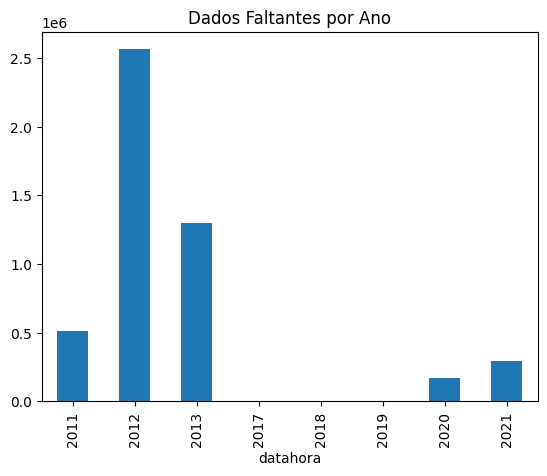

In [12]:
df_missing.groupby(df['datahora'].dt.year).size().plot(kind='bar', title='Dados Faltantes por Ano')

plt.show()

>Considerando o grande volume de dados e a expressiva quantidade de informações ausentes, especialmente em registros anteriores a 2017, optei por restringir a análise ao período de 2017 a 2021, de modo a garantir uma maior consistência dos dados.

In [13]:
df = df[df['datahora'] >= pd.to_datetime('2017-01-01')]

In [14]:
df.isnull().sum()

,0
datahora,0
estado,0
municipio,0
bioma,973
diasemchuva,475664
precipitacao,475664
riscofogo,475664
latitude,0
longitude,0
dia,0


In [15]:
df.shape

(18307829, 13)

* Traratamento de dados faltantes de Biomas


---

>Para tratar os dados faltantes relacionados ao bioma de uma forma eficaz, consideraderei a disponibilidade de informações de latitude e longitude, com o objetivo de identificar a localidade mais próxima e assumir que pertence ao mesmo bioma. Contudo, devido ao grande volume de dados, optei por uma solução que foi agrupar as informações por estado. Assim, a localidade mais próxima será considerada dentro do mesmo estado, facilitando a identificação do bioma adequado.

In [16]:
df_unico = df.drop_duplicates(subset=['municipio', 'estado', 'bioma'])

df_unico['municipio'] = df_unico['municipio'].str.upper()
df_unico['estado'] = df_unico['estado'].str.upper()

df_unico = df_unico[['municipio', 'estado', 'bioma', 'latitude', 'longitude']]

cidades_com_bioma = df_unico[df_unico['bioma'].notnull()]
cidades_sem_bioma = df_unico[df_unico['bioma'].isnull()]

In [17]:
def preencher_bioma_por_estado(df_sem_bioma, df_com_bioma):

    df_sem_bioma_grouped = df_sem_bioma.groupby('estado')
    df_com_bioma_grouped = df_com_bioma.groupby('estado')

    for estado, group_sem_bioma in df_sem_bioma_grouped:

        if estado in df_com_bioma_grouped.groups:
            group_com_bioma = df_com_bioma_grouped.get_group(estado)

            for i, row in group_sem_bioma.iterrows():
                cidade_atual = (row['latitude'], row['longitude'])
                menor_distancia = np.inf
                bioma_mais_proximo = None


                for j, row_vizinha in group_com_bioma.iterrows():
                    cidade_vizinha = (row_vizinha['latitude'], row_vizinha['longitude'])
                    distancia = geodesic(cidade_atual, cidade_vizinha).kilometers

                    if distancia < menor_distancia:
                        menor_distancia = distancia
                        bioma_mais_proximo = row_vizinha['bioma']


                df_sem_bioma.at[i, 'bioma'] = bioma_mais_proximo


    return df_sem_bioma


df_sem_bioma_preenchido = preencher_bioma_por_estado(cidades_sem_bioma, cidades_com_bioma)

In [18]:
df['estado'] = df['estado'].str.upper()
df['municipio'] = df['municipio'].str.upper()

df_sem_bioma_preenchido['estado'] = df_sem_bioma_preenchido['estado'].str.upper()
df_sem_bioma_preenchido['municipio'] = df_sem_bioma_preenchido['municipio'].str.upper()

df_merge = df.merge(df_sem_bioma_preenchido[['estado', 'municipio', 'bioma']],
                      on=['estado', 'municipio'],
                      how='left',
                      suffixes=('', '_preenchido'))


In [19]:
df_merge['bioma'] = df_merge['bioma'].fillna(df_merge['bioma_preenchido'])
df = df_merge.drop(columns=['bioma_preenchido'])

---

> **Nesta etapa do código, devido ao grande volume de dados e às bibliotecas em uso, optei por salvar um arquivo temporário para garantir a continuidade do processamento. Salvei o DataFrame no formato CSV e utilizei o comando %reset -f para limpar o ambiente. Em seguida, reimportei as bibliotecas necessárias e recriei o DataFrame a partir do arquivo CSV.**

In [20]:
df.to_csv('queimadas_tratado.csv', index=False)

In [21]:
%reset -f

In [47]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from scipy.stats import truncnorm

In [24]:
df = pd.read_csv('queimadas_tratado.csv')

---

In [25]:
df.isnull().sum()

,0
datahora,0
estado,0
municipio,0
bioma,0
diasemchuva,475664
precipitacao,475664
riscofogo,475664
latitude,0
longitude,0
dia,0


* Análise de Anomalias: Valores Negativos Inesperados

---

In [26]:
colunas_especificas = ['diasemchuva', 'precipitacao', 'riscofogo']
contagem_negativos = (df[colunas_especificas] < 0).sum()
contagem_negativos

,0
diasemchuva,75899
precipitacao,0
riscofogo,152273


* Traratamento de dados faltantes de Risco de Fogo

---

>Para a variável risco de fogo, decidir transformar os valores negativos em dados ausentes, pois esses valores não são válidos dentro do contexto do risco de incêndio.

>Além disso, para lidar com os dados ausentes resultantes dessa transformação, apliquei uma distribuição normal aos valores do risco de fogo, por se tratar de dados contínuos, seguem essa distribuição, caracterizada pela média e pelo desvio padrão. Isso permite que os dados ausentes sejam preenchidos de forma estatisticamente coerente, preservando a integridade dos dados e facilitando análises posteriores sobre os padrões de risco de incêndio nas regiões analisadas.

In [27]:
df.loc[df['riscofogo'] < 0, 'riscofogo'] = np.nan

In [28]:
def preencher_grupo(grupo):
    mean = grupo['riscofogo'].mean()
    std_dev = grupo['riscofogo'].std()

    n_missing = grupo['riscofogo'].isna().sum()
    if n_missing > 0:
        lower_bound = 0
        upper_bound = np.inf

        a, b = (lower_bound - mean) / std_dev, (upper_bound - mean) / std_dev

        valores_preenchidos = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=n_missing)

        grupo.loc[grupo['riscofogo'].isna(), 'riscofogo'] = valores_preenchidos
    return grupo

df = df.groupby(['estado', 'bioma']).apply(preencher_grupo).reset_index(drop=True)


In [29]:
df['riscofogo'].isnull().sum()

0

In [30]:
contagem_negativos = (df['riscofogo'] < 0).sum()
contagem_negativos

0

* Traratamento de dados faltantes de Dias sem Chuvas

---

> Para tratar os dados referentes aos dias sem chuva, transformei os valores negativos em dados ausentes, uma vez que esses valores não têm relevância no contexto da análise. Em relação aos dados ausentes, optei por preenchê-los utilizando a média do mês correspondente, considerando o estado e o bioma em questão. Dessa forma, foi possivel assegurar que a imputação refletisse as características climáticas da região.

> No entanto, ainda restaram dados faltantes após essa etapa. Para esses casos remanescentes, foi utilizado a média do mês para o mesmo bioma, garantindo assim que a abordagem de preenchimento fosse consistente e representativa das condições climáticas específicas do bioma em análise.

In [31]:
df.loc[df['diasemchuva'] < 0, 'diasemchuva'] = np.nan

def preencher_diasemchuva(grupo):
    mean = grupo['diasemchuva'].mean()
    grupo.loc[grupo['diasemchuva'].isna(), 'diasemchuva'] = mean
    return grupo

df = df.groupby(['mes', 'ano', 'estado', 'bioma']).apply(preencher_diasemchuva).reset_index(drop=True)

df = df.groupby(['mes', 'ano', 'bioma']).apply(preencher_diasemchuva).reset_index(drop=True)



<Axes: >

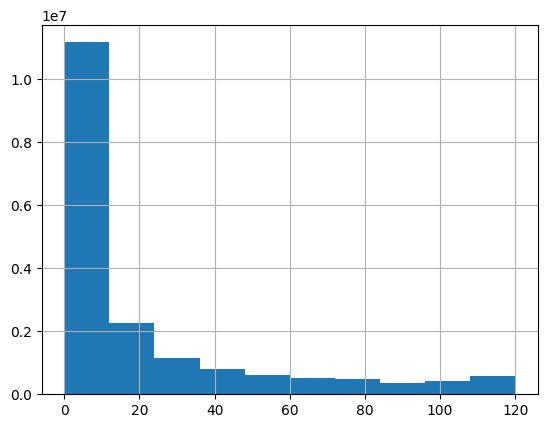

In [32]:
df['diasemchuva'].hist()


> O gráfico revela a ausência de dados negativos para os dias sem chuva, o que elimina potenciais incoerências. Além disso, demonstra que os incêndios ocorrem com alta frequência em períodos de 0 a 20 dias sem chuva

* Traratamento de dados faltantes de Precipitação

---

> Para tratar os dados ausentes de precipitação, foi preenchido com as medianas dos valores, agrupando os dados por mês, bioma e estado. Essa abordagem é eficaz, pois a mediana é menos suscetível a outliers, proporcionando uma representação robusta das condições típicas de precipitação na região. Assim, garantiu-se que os dados preenchidos fossem consistentes e refletissem adequadamente as características climáticas específicas do bioma em questão.

In [34]:
def preencher_diasemchuva(grupo):
    mean = grupo['precipitacao'].mean()
    grupo.loc[grupo['precipitacao'].isna(), 'precipitacao'] = mean
    return grupo

df = df.groupby(['mes', 'ano', 'estado', 'bioma']).apply(preencher_diasemchuva).reset_index(drop=True)

df = df.groupby(['mes', 'ano', 'bioma']).apply(preencher_diasemchuva).reset_index(drop=True)

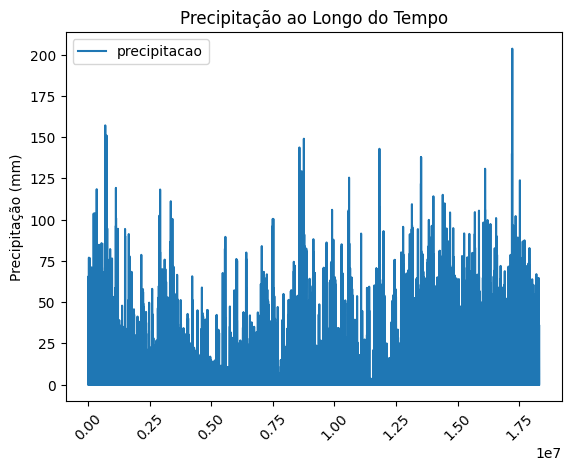

In [35]:
analise = ['precipitacao']
df[analise].plot(title='Precipitação ao Longo do Tempo', ylabel='Precipitação (mm)')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

>O gráfico apresentado indica que não há valores negativos de precipitação, além de evidenciar picos significativos ao longo do tempo. Esses picos refletem índices elevados de chuva, mesmo na presença de queimadas.

In [36]:
df.isnull().sum()

,0
datahora,0
estado,0
municipio,0
bioma,0
diasemchuva,0
precipitacao,0
riscofogo,0
latitude,0
longitude,0
dia,0


**4. Análise exploratória de dados**

---

In [37]:
df.head()

,datahora,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,dia,ano,mes,hora
0,2017-01-29 23:39:17,ACRE,RIO BRANCO,Amazonia,0.0,10.5,0.0,-10.37930,-68.92670,29,2017,1,23
1,2017-01-08 17:30:00,ACRE,FEIJO,Amazonia,0.0,0.5,0.0,-8.84000,-70.01000,8,2017,1,17
2,2017-01-07 18:30:00,ACRE,SENA MADUREIRA,Amazonia,0.0,1.5,0.0,-9.66000,-68.88000,7,2017,1,18
3,2017-01-02 18:50:00,ACRE,EPITACIOLANDIA,Amazonia,0.0,1.0,0.5,-10.86316,-68.42573,2,2017,1,18
4,2017-01-04 18:12:00,ACRE,XAPURI,Amazonia,0.0,0.2,0.1,-10.89709,-68.40035,4,2017,1,18


Diante da necessidade de identificar se há períodos mais suscetíveis a queimadas, optou-se por criar uma nova variável de tempo, representando as estações do ano

In [38]:
def estacao(mes):
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    elif mes in [9, 10, 11]:
        return 'Primavera'
    return 'Desconhecida'

df['estacao'] = df['mes'].apply(estacao)

In [39]:
pd.set_option('display.float_format', '{:.2f}'.format)
analise = ['diasemchuva','precipitacao','riscofogo','hora','ano','mes','hora','dia','estacao']
df[analise].describe()

,diasemchuva,precipitacao,riscofogo,hora,ano,mes,hora,dia
count,18307829.00,18307829.00,18307829.00,18307829.00,18307829.00,18307829.00,18307829.00,18307829.00
mean,20.90,0.73,0.78,13.60,2019.35,8.62,13.60,15.33
std,30.33,3.26,0.33,6.55,1.36,1.91,6.55,8.59
min,0.00,0.00,0.00,0.00,2017.00,1.00,0.00,1.00
25%,2.00,0.00,0.60,5.00,2018.00,8.00,5.00,8.00
50%,7.00,0.00,1.00,16.00,2020.00,9.00,16.00,15.00
75%,26.00,0.10,1.00,17.00,2020.00,10.00,17.00,22.00
max,120.00,203.70,2.14,23.00,2021.00,12.00,23.00,31.00


In [40]:
analise =  ['estado','municipio','bioma', 'diasemchuva','precipitacao','riscofogo','dia','ano','mes','hora','estacao']
df[analise].mode()

,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,dia,ano,mes,hora,estacao
0,MATO GROSSO,CORUMBA,Amazonia,0.00,0.00,1.00,13,2020,9,16,Primavera


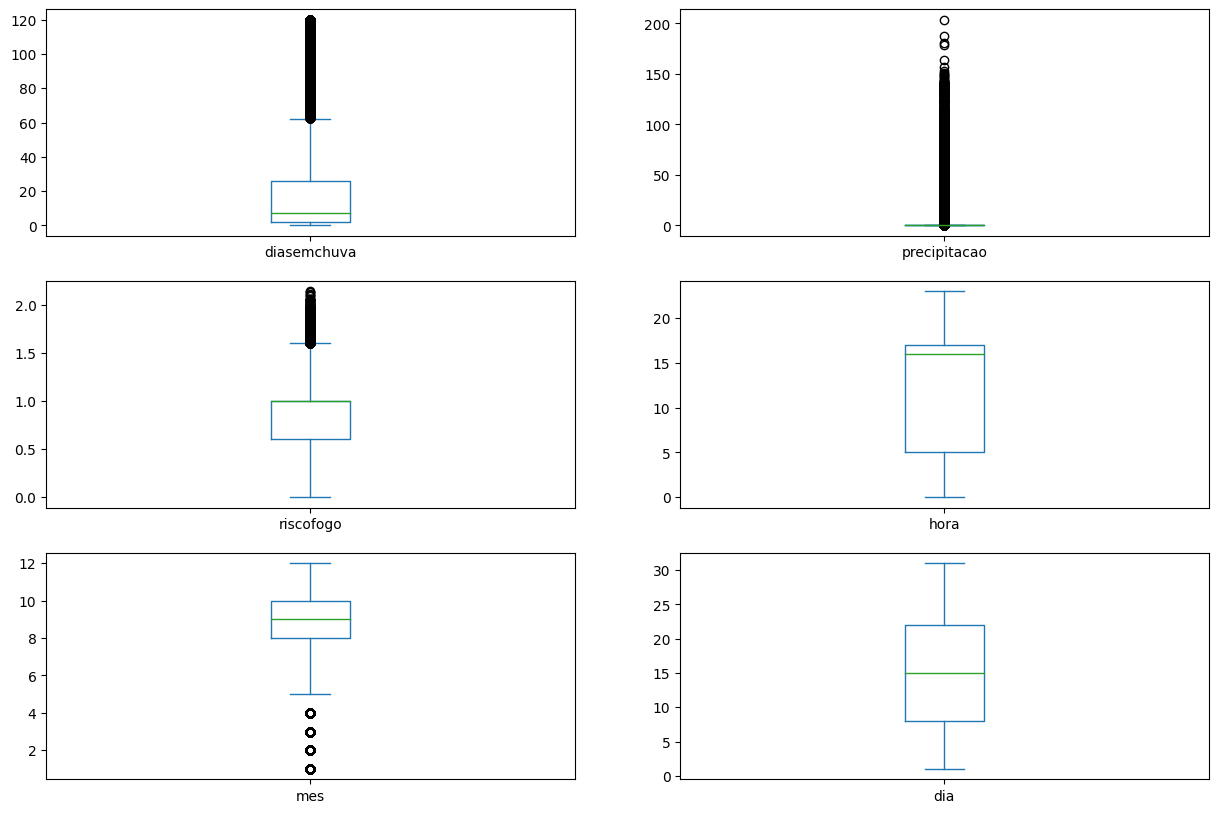

In [41]:
analise = ['diasemchuva','precipitacao', 'riscofogo','hora','mes', 'dia']

df[analise].plot(kind='box', subplots=True, layout=(3, 2), sharex=False, sharey=False, figsize=(15, 10))
plt.show()

Ao elaborar o boxplot, foi identificado muitos outliers. No entanto, dado o grande volume de dados analisados, esses outliers não devem ser descartados, pois estão coerentes com o comportamento esperado das variáveis. Podemos observar o seguinte em cada box plot:

* Dias sem chuva: A variável apresentou uma média em torno de 20 dias, mas com vários outliers acima de 70. Esses valores refletem regiões com períodos prolongados de estiagem, que são consistentes com padrões climáticos regionais, justificando a presença de outliers.

* Precipitação: Embora a média seja baixa, diversos outliers indicam chuvas intensas em alguns momentos. Esses picos são compatíveis com eventos extremos e podem estar associados a variações sazonais ou regionais, sem indicar erros nos dados.

* Risco de fogo: A distribuição mostrou uma concentração no terceiro quartil, com outliers na parte superior. Esses outliers são coerentes, dado que períodos de maior risco de fogo podem ocorrer em situações excepcionais, como secas prolongadas ou condições climáticas extremas.

* Hora do dia: Os dados mostraram uma concentração em torno das 15h, com alguns outliers em horários fora do padrão. Esses valores podem refletir casos específicos em que as queimadas ocorrem em horários menos comuns, mas são consistentes com o comportamento variável do fenômeno.

* Meses: A distribuição mensal apresentou uma concentração em torno de setembro, com outliers nos meses anteriores a maio. Isso é esperado, pois o período de maior incidência de queimadas costuma ocorrer no segundo semestre, sendo os valores fora desse intervalo representações de variações climáticas regionais.

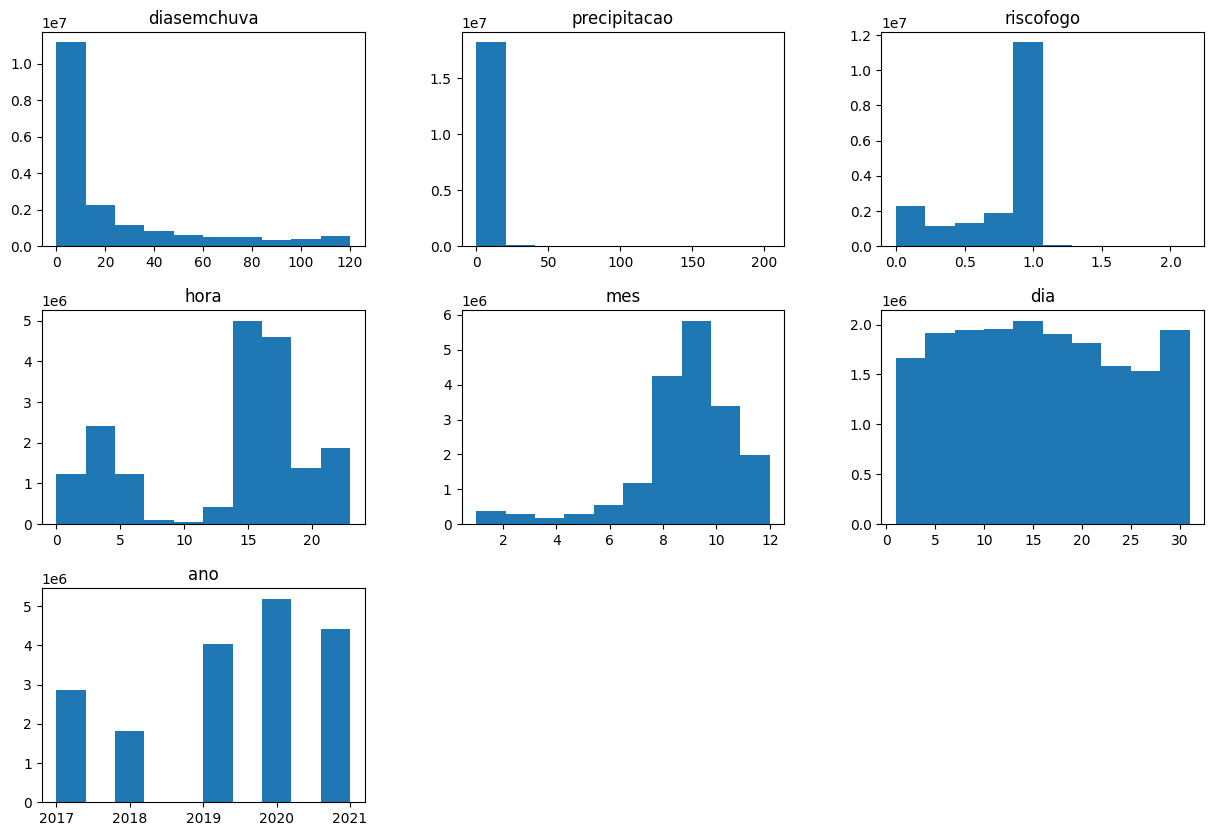

In [42]:
analise = ['diasemchuva','precipitacao', 'riscofogo','hora','mes', 'dia', 'ano']

axes = df[analise].hist(figsize = (15,10))
for ax in axes.flatten():
    ax.grid(False)

plt.show()

> Nesta seção, são apresentados os histogramas das variáveis analisadas, demonstrando a incidência das queimadas e o comportamento no período estudado. Esses gráficos permitem visualizar a distribuição das variáveis, facilitando a identificação de padrões e tendências relacionadas às queimadas.

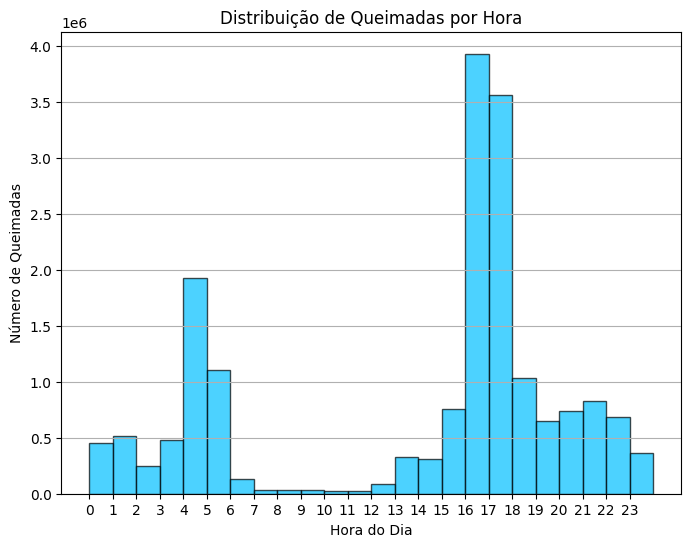

In [43]:
plt.figure(figsize=(8, 6))
plt.hist(df['hora'], bins=24, range=(0, 24), edgecolor='black', alpha=0.7, color = 'deepskyblue')
plt.title('Distribuição de Queimadas por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Queimadas')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()


> Ao analisar o gráfico de Distribuiçã de Queimadas por Hora foi possivel identificar uma grande numero de ocorrências no período correspondente entre 16h e 18h. Esse padrão não é isolado e pode estar relacionado ao horário de atividade laboral, coincidindo com o término do expediente.

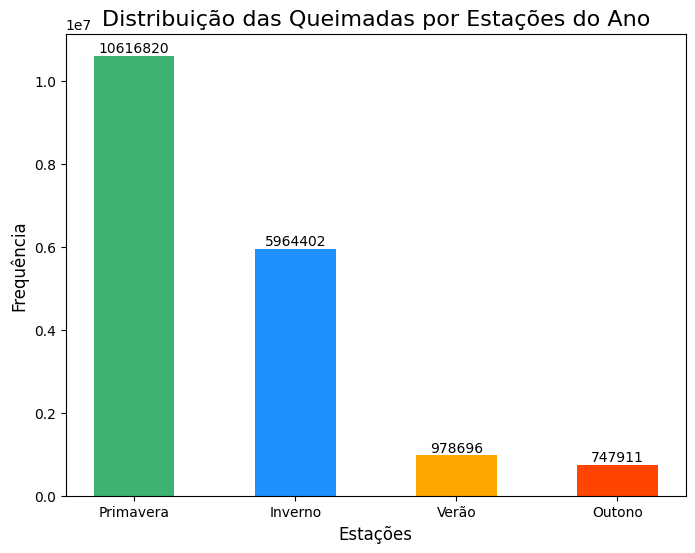

In [44]:
estacao_counts = df['estacao'].value_counts()

colors = ['mediumseagreen', 'dodgerblue', 'orange', 'orangered']

plt.figure(figsize=(8, 6))
bars = plt.bar(estacao_counts.index, estacao_counts.values, color=colors[:len(estacao_counts)], width=0.5)

plt.title('Distribuição das Queimadas por Estações do Ano', fontsize=16)
plt.xlabel('Estações', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom', fontsize=10, color='black')

plt.grid(False)
plt.show()

> Análise da Distribuição das Queimadas por Estação: Neste histograma, que relaciona as estações do ano, observa-se uma prevalência das queimadas no inverno e na primavera em comparação com as outras estações. Esse fenômeno pode estar associado ao fato de que, durante esse período, grande parte do país apresenta condições mais secas, tornando-se mais propenso a essas ocorrências.

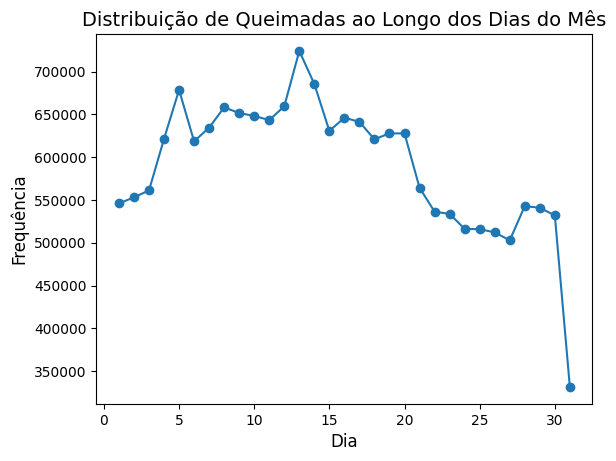

In [45]:
frequencia_dia = df['dia'].value_counts().sort_index()

plt.plot(frequencia_dia.index, frequencia_dia.values, marker='o')

plt.title('Distribuição de Queimadas ao Longo dos Dias do Mês', fontsize=14)
plt.xlabel('Dia', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.show()

> Nesta análise da distribuição de ocorrências de queimadas ao longo dos dias do mÊs, é possível observar a existência de picos em torno doa dias 6 e 14, além de valores elevados entre os dias 5 a 19, quando comparados ao restante dos dias do mês.

In [48]:
le_bioma = LabelEncoder()
le_estado = LabelEncoder()
le_estacao = LabelEncoder()

df['bioma_encoded'] = le_bioma.fit_transform(df['bioma'])
df['estado_encoded'] = le_estado.fit_transform(df['estado'])
df['estacao_encoded'] = le_estacao.fit_transform(df['estacao'])

heatmap_data = df[['riscofogo', 'hora', 'ano', 'mes', 'precipitacao', 'diasemchuva', 'bioma_encoded', 'estado_encoded', 'estacao_encoded']]

correlation_matrix = heatmap_data.corr()

fig = px.imshow(
    correlation_matrix,
    labels=dict(x='Variáveis', y='Variáveis', color='Correlação'),
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    title='Correlação com Variáveis Codificadas',
    color_continuous_scale='RdBu_r'
)

fig.show()


 > Neste heatmap, é possível observar uma correlação positiva entre as variáveis "dias sem chuva" e "risco de fogo", indicando que quanto maior o período de dias sem precipitação, maior é o risco de incêndios florestais. Por outro lado, também se destaca uma correlação negativa entre a quantidade de precipitação e a redução do risco de fogo, sugerindo que chuvas adequadas podem desempenhar um papel crucial na mitigação das condições que favorecem queimadas. Esses padrões ressaltam a importância de monitorar essas variáveis para implementar estratégias de prevenção e gestão de riscos de incêndios.

In [49]:
quantidade_por_estado = df['estado'].value_counts().reset_index()
quantidade_por_estado.columns = ['estado', 'quantidade']

fig = px.bar(
    quantidade_por_estado,
    x='quantidade',
    y='estado',
    title='Quantidade de Ocorrências por Estado',
    labels={'quantidade': 'Quantidade', 'estado': 'Estado'},
    color='quantidade',
    color_continuous_scale='Blues',
    orientation='h'
)


fig.update_layout(height=600)

fig.show()

> Neste gráfico são apresentados os estados com maior incidência de queimadas. É fundamental que o governo federal implemente iniciativas específicas para combater essas queimadas, especialmente nos estados que registram os maiores índices de ocorrência.

In [50]:
quantidade_por_bioma = df['bioma'].value_counts().reset_index()
quantidade_por_bioma.columns = ['bioma', 'quantidade']

fig = px.treemap(
    quantidade_por_bioma,
    path=['bioma'],
    values='quantidade',
    title='Quantidade de Ocorrências por Bioma',
    color='quantidade',
    color_continuous_scale = 'Blues',
    hover_data={'quantidade': True}
)


fig.show()

> Neste gráfico, são apresentados os biomas com maior incidência de queimadas, destacando a necessidade urgente de preservação dessas áreas. O cerrado, em particular, merece atenção especial devido às suas características únicas e à sua importância ecológica. Este bioma não apenas abriga uma rica biodiversidade, mas também desempenha um papel crucial na regulação climática e na manutenção dos recursos hídricos. Além disso, a Amazônia, reconhecida mundialmente por sua importância na captura de carbono e na conservação da biodiversidade, também enfrenta desafios significativos relacionados às queimadas. Portanto, é imperativo que sejam implementadas políticas eficazes de proteção e recuperação desses biomas, a fim de garantir a sustentabilidade ambiental e a preservação dos recursos naturais para as futuras gerações

In [51]:
quantidade_por_municipio = df['municipio'].value_counts().reset_index()
quantidade_por_municipio.columns = ['municipio', 'quantidade']

municipios = quantidade_por_municipio.head(20)

fig = px.treemap(municipios,
                 path=['municipio'],
                 values='quantidade',
                 title='Reação dos 20 Municípios com Maior Quantidade de Queimadas',
                 color='quantidade',
                 color_continuous_scale='RdBu_r')

fig.show()



> Por último, apresentamos a relação dos 20 municípios com o maior número de ocorrências de queimadas. Essa concentração de eventos indica a necessidade urgente de políticas públicas eficazes voltadas para a mitigação das queimadas nessas áreas. É fundamental que as autoridades reconheçam a gravidade da situação e implementem medidas preventivas.

---

**5. Respostas ao checklist**

---

* Que premissas ou hipóteses você tem sobre o problema?

> **1- Modelagem preditiva: A suposição de que um modelo de aprendizado de máquina pode capturar e generalizar os padrões nos dados históricos para prever a ocorrência de queimadas em novas localidades.**

>**2-A premissa de que localidades com histórico de queimadas são mais propensas a novos incidentes. O padrão histórico pode ser um indicador significativo para a previsão de riscos futuros.**

* Que restrições ou condições foram impostas para selecionar os dados?

> **1- As restrições para a seleção dos dados incluem o período de análise, focando exclusivamente nos dados coletados entre 2017 e 2021. Além disso, a localidade da análise é restrita ao território brasileiro, com ênfase nos biomas presentes no Brasil.**

* Quantos atributos e instâncias existem?

In [52]:
df.shape

(18307829, 17)

* Quais são os tipos de dados dos atributos?

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18307829 entries, 0 to 18307828
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   datahora         object 
 1   estado           object 
 2   municipio        object 
 3   bioma            object 
 4   diasemchuva      float64
 5   precipitacao     float64
 6   riscofogo        float64
 7   latitude         float64
 8   longitude        float64
 9   dia              int64  
 10  ano              int64  
 11  mes              int64  
 12  hora             int64  
 13  estacao          object 
 14  bioma_encoded    int64  
 15  estado_encoded   int64  
 16  estacao_encoded  int64  
dtypes: float64(5), int64(7), object(5)
memory usage: 2.3+ GB


* Há valores faltantes, discrepantes ou inconsistentes?

> **No momento, não há valores faltantes, discrepantes ou inconsistentes nos dados. No início do trabalho, haviam valores ausentes nas seguintes colunas:**

>* Bioma: 1.000 valores faltantes
>* Dias sem chuva: 4.855.864 valores faltantes e 75.899 valores negativos
>* Precipitação: 4.855.864 valores faltantes
>* Risco de fogo: 152.273 valores negativo

* Verifique quais operações de pré-processamento podem ser interessantes para o seu problema e salve visões diferentes do seu dataset (por exemplo, normalização, padronização, discretização e one-hot-encoding).

> **Foi utilizado o One-Hot Encoding para as variáveis de biomas, estação e estado na criação do heatmap. A análise das variáveis estado, estação e bioma revelou uma relação negativa entre estação e risco de fogo.**


---